# Cross-Region Comparison: BLA vs mPFC Receptor Expression

This notebook compares neuromodulator receptor expression between the
**basolateral amygdala (BLA)** and **medial prefrontal cortex (mPFC)** for
shared cell types (interneurons and glia), within each data modality.

### Rationale
Interneuron subclasses (Pvalb, Sst, Vip, Lamp5, Sncg) and glia (astrocytes,
microglia) are present in both regions with the same transcriptomic identities.
Comparing their receptor profiles across regions reveals:
- Which receptor–cell-type patterns are **conserved** across brain areas
- Which are **region-specific** (potential targets for selective manipulation)

Excitatory neurons are excluded — BLA has region-specific types (LA-BLA-BMA-PA Glut)
while mPFC has cortical layer types (L2/3 IT, L5 ET, etc.) with no direct match.

### Two Modalities
- **MERFISH** (11 shared receptor genes): Spatially resolved, truly region-specific
  cells via CCF parcellation in both regions
- **10x snRNA-seq** (28 receptor genes): Full receptor set, but BLA interneurons
  are CTXsp-wide (not BLA-exclusive) — a known caveat

### Data
All loaded from pre-extracted CSVs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import re

## 1. Load Data

In [2]:
# BLA
bla_10x_neur = pd.read_csv('bla_10x_neuronal_expression.csv', index_col=0)
bla_10x_glia = pd.read_csv('bla_10x_glia_expression.csv', index_col=0)
bla_10x_expr = pd.concat([bla_10x_neur, bla_10x_glia])
bla_10x_meta = pd.read_csv('bla_10x_metadata.csv', index_col=0)

bla_mer_expr = pd.read_csv('bla_merfish_expression.csv', index_col=0)
bla_mer_meta = pd.read_csv('bla_merfish_metadata.csv', index_col=0)

# mPFC
mpfc_10x_neur = pd.read_csv('mpfc_receptor_expression.csv', index_col=0)
mpfc_10x_glia = pd.read_csv('mpfc_glia_receptor_expression.csv', index_col=0)
mpfc_10x_expr = pd.concat([mpfc_10x_neur, mpfc_10x_glia])
mpfc_10x_meta = pd.read_csv('mpfc_10x_metadata.csv', index_col=0)

mpfc_mer_expr = pd.read_csv('mpfc_merfish_expression.csv', index_col=0)
mpfc_mer_meta = pd.read_csv('mpfc_merfish_metadata.csv', index_col=0)

print('Loaded:')
for name, e in [('BLA 10x', bla_10x_expr), ('BLA MERFISH', bla_mer_expr),
                ('mPFC 10x', mpfc_10x_expr), ('mPFC MERFISH', mpfc_mer_expr)]:
    print(f'  {name:15s}: {len(e):>7,} cells x {e.shape[1]} genes')

Loaded:
  BLA 10x        :  54,113 cells x 28 genes
  BLA MERFISH    :   8,238 cells x 11 genes
  mPFC 10x       : 187,279 cells x 28 genes
  mPFC MERFISH   :  64,474 cells x 11 genes


## 2. Identify Shared Cell Types

Find interneuron and glia subclasses present in both BLA and mPFC for each modality.

In [3]:
def strip_prefix(name):
    return re.sub(r'^\d+\s+', '', str(name))

def get_subclass_set(meta):
    return set(meta['subclass'].apply(strip_prefix).unique())

# Interneuron + glia keywords (exclude excitatory)
def is_shared_type(name):
    """Return True for interneuron or glia types (not region-specific excitatory)."""
    return ('Gaba' in name or 'NN' in name)

# MERFISH shared types
bla_mer_sc = get_subclass_set(bla_mer_meta)
mpfc_mer_sc = get_subclass_set(mpfc_mer_meta)
mer_shared = sorted([s for s in (bla_mer_sc & mpfc_mer_sc) if is_shared_type(s)])

# 10x shared types
bla_10x_sc = get_subclass_set(bla_10x_meta)
mpfc_10x_sc = get_subclass_set(mpfc_10x_meta)
tenx_shared = sorted([s for s in (bla_10x_sc & mpfc_10x_sc) if is_shared_type(s)])

print(f'MERFISH shared interneuron + glia types ({len(mer_shared)}):')
for s in mer_shared:
    print(f'  {s}')

print(f'\n10x shared interneuron + glia types ({len(tenx_shared)}):')
for s in tenx_shared:
    print(f'  {s}')

MERFISH shared interneuron + glia types (8):
  Astro-TE NN
  Lamp5 Gaba
  Microglia NN
  Pvalb Gaba
  Pvalb chandelier Gaba
  Sncg Gaba
  Sst Gaba
  Vip Gaba

10x shared interneuron + glia types (10):
  Astro-TE NN
  Lamp5 Gaba
  Lamp5 Lhx6 Gaba
  Microglia NN
  Pvalb Gaba
  Pvalb chandelier Gaba
  Sncg Gaba
  Sst Chodl Gaba
  Sst Gaba
  Vip Gaba


## 3. Compute Per-Subclass Statistics

In [4]:
def compute_stats(expr_df, meta_df, genes, subclasses):
    """Compute mean and fraction expressing per subclass for given genes."""
    common = expr_df.index.intersection(meta_df.index)
    expr = expr_df.loc[common, [g for g in genes if g in expr_df.columns]].copy()
    meta = meta_df.loc[common].copy()
    meta['sc_short'] = meta['subclass'].apply(strip_prefix)
    expr['subclass'] = meta['sc_short'].values
    
    # Filter to desired subclasses
    expr = expr[expr['subclass'].isin(subclasses)]
    genes_avail = [g for g in genes if g in expr.columns and g != 'subclass']
    
    mean_expr = expr.groupby('subclass')[genes_avail].mean()
    frac_expr = expr.groupby('subclass')[genes_avail].apply(lambda x: (x > 0).mean())
    
    # Reindex to ensure consistent ordering
    present = [s for s in subclasses if s in mean_expr.index]
    return mean_expr.loc[present], frac_expr.loc[present], present

# Gene lists
merfish_genes = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7',
                 'Adra1a', 'Adra1b', 'Drd1', 'Drd2', 'Drd3', 'Drd5']

tenx_genes = [
    'Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b', 'Htr2c',
    'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7',
    'Adra1a', 'Adra1b', 'Adra1d', 'Adra2a', 'Adra2b', 'Adra2c',
    'Adrb1', 'Adrb2', 'Adrb3',
    'Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5'
]

# MERFISH stats
bla_mer_mean, bla_mer_frac, mer_shared_final = compute_stats(
    bla_mer_expr, bla_mer_meta, merfish_genes, mer_shared)
mpfc_mer_mean, mpfc_mer_frac, _ = compute_stats(
    mpfc_mer_expr, mpfc_mer_meta, merfish_genes, mer_shared_final)

# 10x stats
bla_10x_mean, bla_10x_frac, tenx_shared_final = compute_stats(
    bla_10x_expr, bla_10x_meta, tenx_genes, tenx_shared)
mpfc_10x_mean, mpfc_10x_frac, _ = compute_stats(
    mpfc_10x_expr, mpfc_10x_meta, tenx_genes, tenx_shared_final)

print(f'MERFISH: {len(mer_shared_final)} shared cell types, {len(merfish_genes)} genes')
print(f'  BLA mean shape:  {bla_mer_mean.shape}')
print(f'  mPFC mean shape: {mpfc_mer_mean.shape}')
print(f'\n10x: {len(tenx_shared_final)} shared cell types, {len(tenx_genes)} genes')
print(f'  BLA mean shape:  {bla_10x_mean.shape}')
print(f'  mPFC mean shape: {mpfc_10x_mean.shape}')

# Cell counts per shared type
print(f'\nMERFISH cell counts:')
for sc in mer_shared_final:
    bla_n = (bla_mer_meta['subclass'].apply(strip_prefix) == sc).sum()
    mpfc_n = (mpfc_mer_meta['subclass'].apply(strip_prefix) == sc).sum()
    print(f'  {sc:<28s}  BLA={bla_n:>5,}  mPFC={mpfc_n:>5,}')

print(f'\n10x cell counts:')
for sc in tenx_shared_final:
    bla_n = (bla_10x_meta['subclass'].apply(strip_prefix) == sc).sum()
    mpfc_n = (mpfc_10x_meta['subclass'].apply(strip_prefix) == sc).sum()
    print(f'  {sc:<28s}  BLA={bla_n:>5,}  mPFC={mpfc_n:>5,}')

MERFISH: 8 shared cell types, 11 genes
  BLA mean shape:  (8, 11)
  mPFC mean shape: (8, 11)

10x: 10 shared cell types, 28 genes
  BLA mean shape:  (10, 28)
  mPFC mean shape: (10, 28)

MERFISH cell counts:
  Astro-TE NN                   BLA=1,832  mPFC=10,162
  Lamp5 Gaba                    BLA=  137  mPFC=  773
  Microglia NN                  BLA=  265  mPFC=1,169
  Pvalb Gaba                    BLA=  322  mPFC=2,595


  Pvalb chandelier Gaba         BLA=   84  mPFC=   91
  Sncg Gaba                     BLA=  144  mPFC=  367
  Sst Gaba                      BLA=  369  mPFC=2,072
  Vip Gaba                      BLA=  280  mPFC=  878

10x cell counts:


  Astro-TE NN                   BLA=19,140  mPFC=14,917
  Lamp5 Gaba                    BLA=1,208  mPFC=5,211


  Lamp5 Lhx6 Gaba               BLA=  678  mPFC=  389
  Microglia NN                  BLA=6,164  mPFC=6,823


  Pvalb Gaba                    BLA=1,343  mPFC=4,852
  Pvalb chandelier Gaba         BLA=  418  mPFC=  282


  Sncg Gaba                     BLA=1,086  mPFC=2,452
  Sst Chodl Gaba                BLA=  448  mPFC=  418


  Sst Gaba                      BLA=2,609  mPFC=9,267
  Vip Gaba                      BLA=2,081  mPFC=7,209


## 4. MERFISH: BLA vs mPFC Scatter Plots

Overall scatter of BLA vs mPFC expression for all (gene × cell type) combinations,
using the 11 MERFISH receptor genes and spatially confirmed cells.

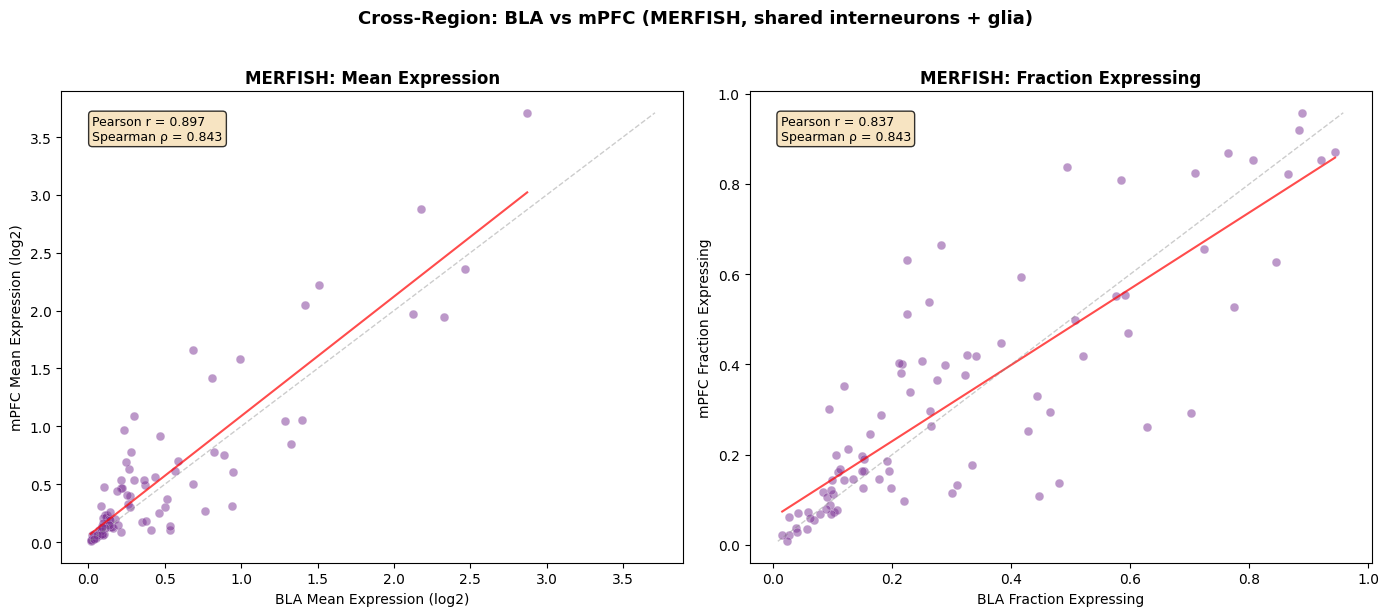

Saved: cross_region_scatter_merfish.png


In [5]:
def scatter_correlation(ax, x, y, xlabel, ylabel, title, color='steelblue'):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    ax.scatter(x, y, alpha=0.5, s=40, c=color, edgecolors='white', linewidth=0.3)
    if len(x) > 2:
        r_p, _ = stats.pearsonr(x, y)
        r_s, _ = stats.spearmanr(x, y)
        z = np.polyfit(x, y, 1)
        xline = np.linspace(x.min(), x.max(), 100)
        ax.plot(xline, np.polyval(z, xline), 'r-', alpha=0.7, linewidth=1.5)
        ax.text(0.05, 0.95, f'Pearson r = {r_p:.3f}\nSpearman \u03c1 = {r_s:.3f}',
                transform=ax.transAxes, va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    # Identity line
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    ax.plot(lims, lims, '--', color='grey', alpha=0.4, linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter_correlation(axes[0],
    bla_mer_mean.values.flatten(), mpfc_mer_mean.values.flatten(),
    'BLA Mean Expression (log2)', 'mPFC Mean Expression (log2)',
    'MERFISH: Mean Expression', color='#7b3294')

scatter_correlation(axes[1],
    bla_mer_frac.values.flatten(), mpfc_mer_frac.values.flatten(),
    'BLA Fraction Expressing', 'mPFC Fraction Expressing',
    'MERFISH: Fraction Expressing', color='#7b3294')

plt.suptitle('Cross-Region: BLA vs mPFC (MERFISH, shared interneurons + glia)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('cross_region_scatter_merfish.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: cross_region_scatter_merfish.png')

## 5. MERFISH: Per-Gene and Per-Cell-Type Correlations

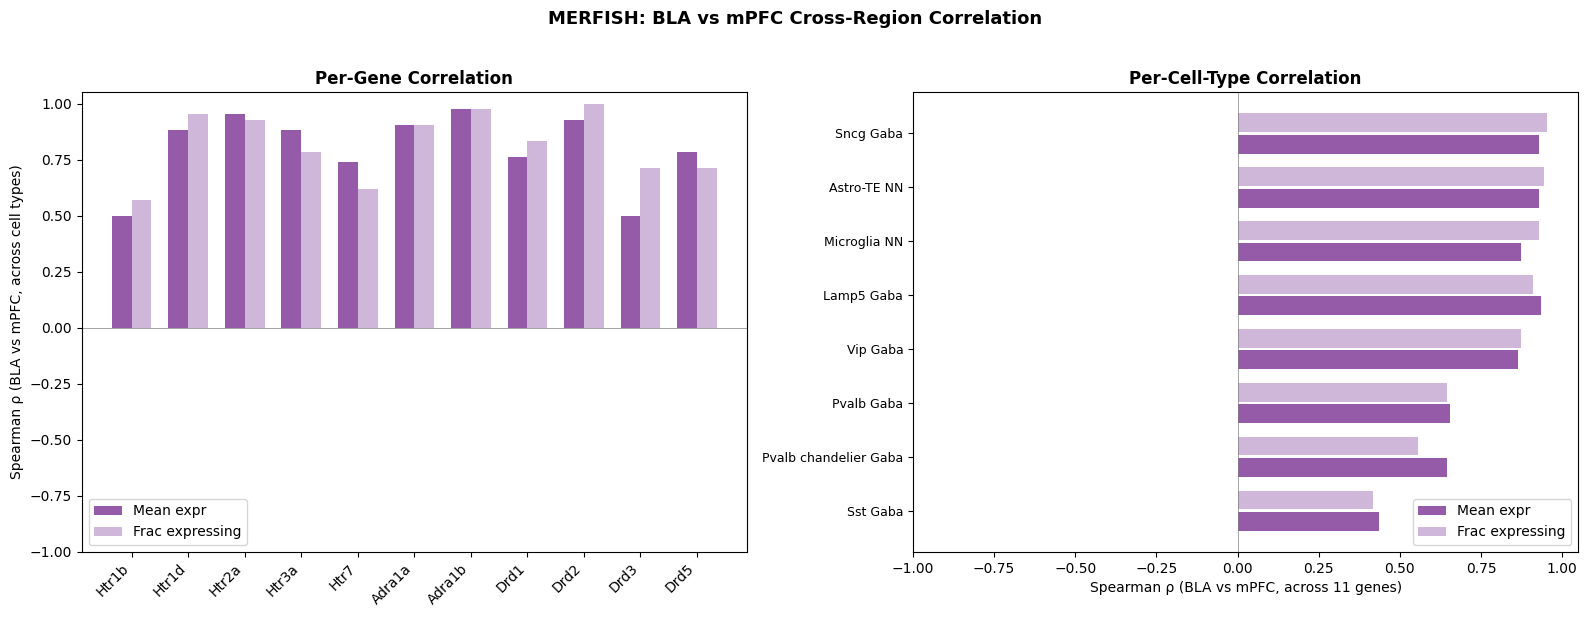

Saved: cross_region_per_gene_merfish.png

MERFISH per-gene (BLA vs mPFC):


,rho_mean,p_mean,rho_frac,p_frac
gene,,,,
Htr1b,0.500,0.207,0.571,0.139
Htr1d,0.881,0.004,0.952,0.000
Htr2a,0.952,0.000,0.929,0.001
Htr3a,0.881,0.004,0.786,0.021
Htr7,0.738,0.037,0.619,0.102
Adra1a,0.905,0.002,0.905,0.002
Adra1b,0.976,0.000,0.976,0.000
Drd1,0.762,0.028,0.833,0.010
Drd2,0.929,0.001,1.000,0.000



MERFISH per-cell-type (BLA vs mPFC):


,rho_mean,p_mean,rho_frac,p_frac
subclass,,,,
Astro-TE NN,0.927,0.000,0.945,0.000
Lamp5 Gaba,0.936,0.000,0.909,0.000
Microglia NN,0.873,0.000,0.927,0.000
Pvalb Gaba,0.655,0.029,0.645,0.032
Pvalb chandelier Gaba,0.645,0.032,0.556,0.076
Sncg Gaba,0.927,0.000,0.955,0.000
Sst Gaba,0.436,0.180,0.418,0.201
Vip Gaba,0.864,0.001,0.873,0.000


In [6]:
def per_gene_corr(mean_a, mean_b, frac_a, frac_b, genes):
    results = []
    for g in genes:
        if g in mean_a.columns and g in mean_b.columns:
            r_m, p_m = stats.spearmanr(mean_a[g], mean_b[g])
            r_f, p_f = stats.spearmanr(frac_a[g], frac_b[g])
            results.append({'gene': g, 'rho_mean': r_m, 'p_mean': p_m,
                            'rho_frac': r_f, 'p_frac': p_f})
    return pd.DataFrame(results).set_index('gene')

def per_ct_corr(mean_a, mean_b, frac_a, frac_b):
    results = []
    for sc in mean_a.index:
        r_m, p_m = stats.spearmanr(mean_a.loc[sc], mean_b.loc[sc])
        r_f, p_f = stats.spearmanr(frac_a.loc[sc], frac_b.loc[sc])
        results.append({'subclass': sc, 'rho_mean': r_m, 'p_mean': p_m,
                        'rho_frac': r_f, 'p_frac': p_f})
    return pd.DataFrame(results).set_index('subclass')

mer_gene_corr = per_gene_corr(bla_mer_mean, mpfc_mer_mean,
                               bla_mer_frac, mpfc_mer_frac, merfish_genes)
mer_ct_corr = per_ct_corr(bla_mer_mean, mpfc_mer_mean,
                           bla_mer_frac, mpfc_mer_frac)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Per-gene
x = np.arange(len(mer_gene_corr))
w = 0.35
axes[0].bar(x - w/2, mer_gene_corr['rho_mean'], w, label='Mean expr', color='#7b3294', alpha=0.8)
axes[0].bar(x + w/2, mer_gene_corr['rho_frac'], w, label='Frac expressing', color='#c2a5cf', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(mer_gene_corr.index, rotation=45, ha='right')
axes[0].set_ylabel('Spearman \u03c1 (BLA vs mPFC, across cell types)')
axes[0].set_title('Per-Gene Correlation', fontweight='bold')
axes[0].legend()
axes[0].axhline(0, color='grey', linewidth=0.5)
axes[0].set_ylim(-1.0, 1.05)

# Per-cell-type
ct_sorted = mer_ct_corr.sort_values('rho_frac', ascending=True)
y = np.arange(len(ct_sorted))
axes[1].barh(y - 0.2, ct_sorted['rho_mean'], 0.35, label='Mean expr', color='#7b3294', alpha=0.8)
axes[1].barh(y + 0.2, ct_sorted['rho_frac'], 0.35, label='Frac expressing', color='#c2a5cf', alpha=0.8)
axes[1].set_yticks(y)
axes[1].set_yticklabels(ct_sorted.index, fontsize=9)
axes[1].set_xlabel('Spearman \u03c1 (BLA vs mPFC, across 11 genes)')
axes[1].set_title('Per-Cell-Type Correlation', fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].axvline(0, color='grey', linewidth=0.5)
axes[1].set_xlim(-1.0, 1.05)

plt.suptitle('MERFISH: BLA vs mPFC Cross-Region Correlation', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('cross_region_per_gene_merfish.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: cross_region_per_gene_merfish.png')

print('\nMERFISH per-gene (BLA vs mPFC):')
display(mer_gene_corr.round(3))
print('\nMERFISH per-cell-type (BLA vs mPFC):')
display(mer_ct_corr.round(3))

## 6. MERFISH: Rank Comparison and Agreement Heatmap

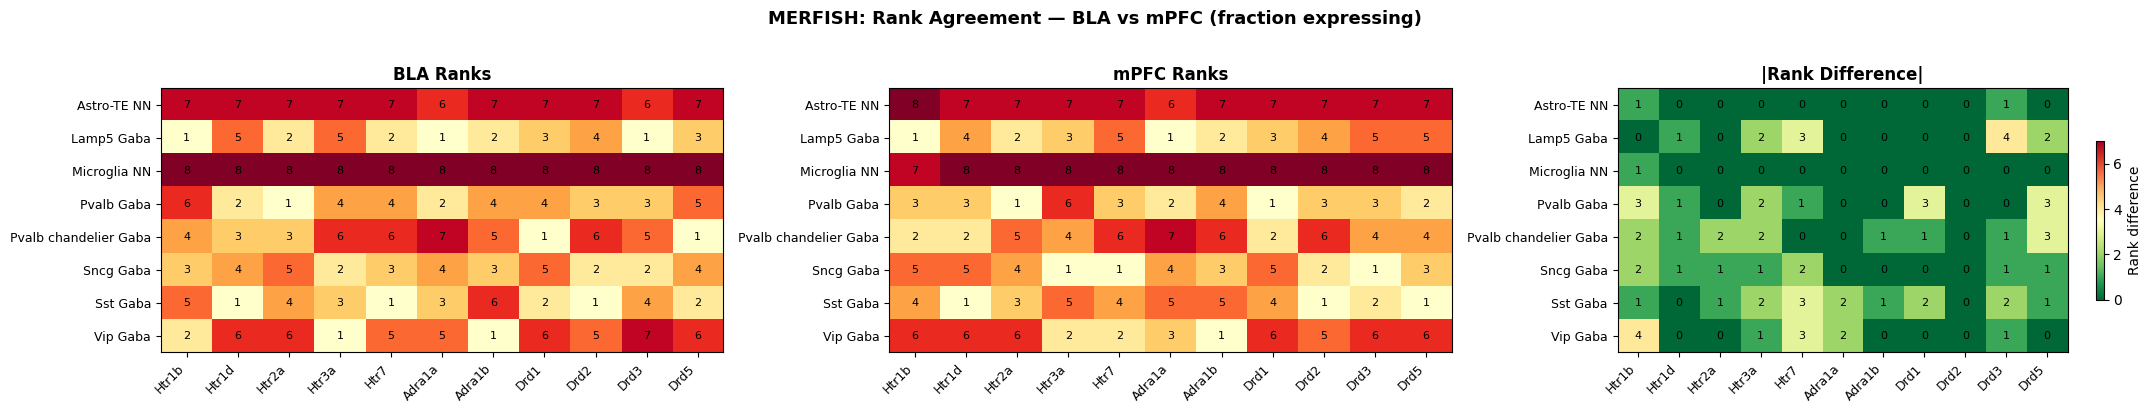

Saved: cross_region_ranks_merfish.png


In [7]:
def compute_ranks(frac_df):
    return frac_df.rank(ascending=False, method='average')

def plot_rank_agreement(ranks_a, ranks_b, genes, cell_types,
                        label_a, label_b, title, filename):
    """Three-panel heatmap: region A ranks, region B ranks, |difference|."""
    rank_diff = (ranks_a[genes] - ranks_b[genes]).abs()
    n_ct = len(cell_types)
    
    fig, axes = plt.subplots(1, 3, figsize=(22, max(4, n_ct * 0.5)),
                             gridspec_kw={'width_ratios': [1, 1, 1]})
    
    for idx, (data, subtitle) in enumerate([
        (ranks_a[genes], f'{label_a} Ranks'),
        (ranks_b[genes], f'{label_b} Ranks'),
        (rank_diff, '|Rank Difference|')
    ]):
        cmap = 'RdYlGn_r' if idx == 2 else 'YlOrRd'
        vmax = n_ct - 1 if idx == 2 else n_ct
        vmin = 0 if idx == 2 else 1
        
        im = axes[idx].imshow(data.values, cmap=cmap, aspect='auto',
                               vmin=vmin, vmax=vmax)
        axes[idx].set_title(subtitle, fontweight='bold')
        axes[idx].set_yticks(range(n_ct))
        axes[idx].set_yticklabels(cell_types, fontsize=9)
        axes[idx].set_xticks(range(len(genes)))
        axes[idx].set_xticklabels(genes, rotation=45, ha='right', fontsize=9)
        
        for i in range(n_ct):
            for j in range(len(genes)):
                val = data.iloc[i, j]
                axes[idx].text(j, i, f'{int(val)}', ha='center', va='center',
                              fontsize=8, color='black')
    
    plt.colorbar(im, ax=axes[2], shrink=0.6, label='Rank difference')
    plt.suptitle(title, fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')
    return rank_diff

# MERFISH ranks
bla_mer_ranks = compute_ranks(bla_mer_frac.loc[mer_shared_final])
mpfc_mer_ranks = compute_ranks(mpfc_mer_frac.loc[mer_shared_final])

mer_rank_diff = plot_rank_agreement(
    bla_mer_ranks, mpfc_mer_ranks, merfish_genes, mer_shared_final,
    'BLA', 'mPFC',
    'MERFISH: Rank Agreement — BLA vs mPFC (fraction expressing)',
    'cross_region_ranks_merfish.png')

## 7. 10x: BLA vs mPFC Scatter Plots

Same cross-region comparison but with the full 28-gene receptor set from 10x data.

**Caveat**: BLA interneurons in 10x are from the full CTXsp dissection region,
not BLA-specific. This may weaken cross-region comparisons for interneurons.

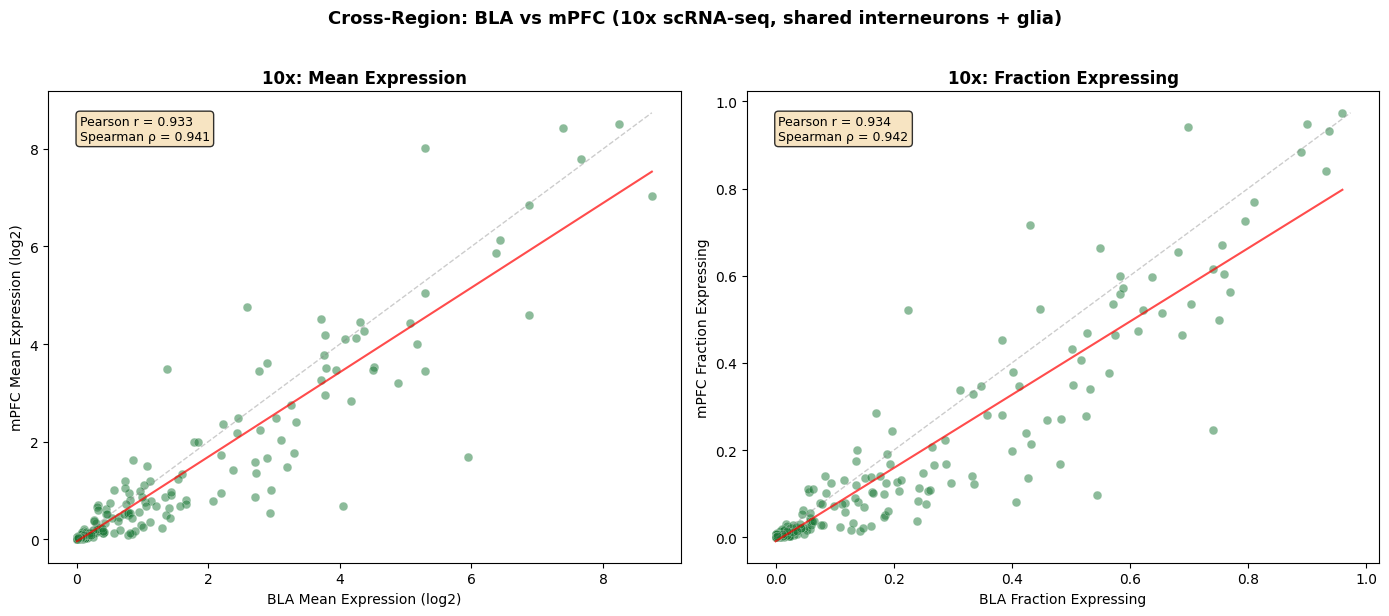

Saved: cross_region_scatter_10x.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter_correlation(axes[0],
    bla_10x_mean.values.flatten(), mpfc_10x_mean.values.flatten(),
    'BLA Mean Expression (log2)', 'mPFC Mean Expression (log2)',
    '10x: Mean Expression', color='#1b7837')

scatter_correlation(axes[1],
    bla_10x_frac.values.flatten(), mpfc_10x_frac.values.flatten(),
    'BLA Fraction Expressing', 'mPFC Fraction Expressing',
    '10x: Fraction Expressing', color='#1b7837')

plt.suptitle('Cross-Region: BLA vs mPFC (10x scRNA-seq, shared interneurons + glia)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('cross_region_scatter_10x.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: cross_region_scatter_10x.png')

## 8. 10x: Per-Gene and Per-Cell-Type Correlations

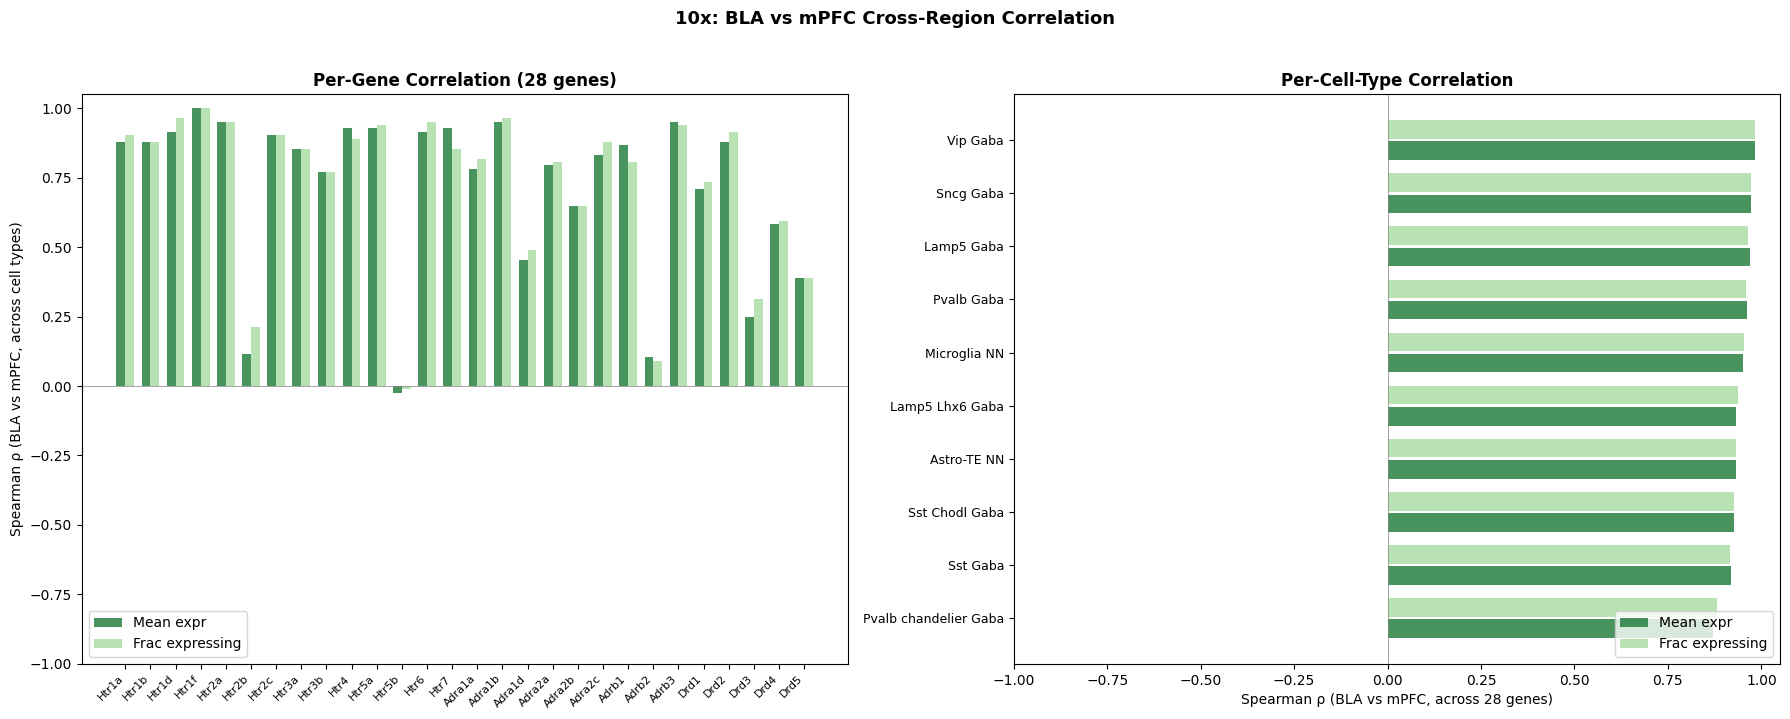

Saved: cross_region_per_gene_10x.png

10x per-gene (BLA vs mPFC):


,rho_mean,p_mean,rho_frac,p_frac
gene,,,,
Htr1a,0.879,0.001,0.903,0.000
Htr1b,0.879,0.001,0.879,0.001
Htr1d,0.915,0.000,0.964,0.000
Htr1f,1.000,0.000,1.000,0.000
Htr2a,0.952,0.000,0.952,0.000
Htr2b,0.115,0.751,0.212,0.556
Htr2c,0.903,0.000,0.903,0.000
Htr3a,0.855,0.002,0.855,0.002
Htr3b,0.771,0.009,0.771,0.009



10x per-cell-type (BLA vs mPFC):


,rho_mean,p_mean,rho_frac,p_frac
subclass,,,,
Astro-TE NN,0.933,0.0,0.932,0.0
Lamp5 Gaba,0.969,0.0,0.965,0.0
Lamp5 Lhx6 Gaba,0.932,0.0,0.938,0.0
Microglia NN,0.950,0.0,0.955,0.0
Pvalb Gaba,0.962,0.0,0.959,0.0
Pvalb chandelier Gaba,0.872,0.0,0.881,0.0
Sncg Gaba,0.973,0.0,0.973,0.0
Sst Chodl Gaba,0.927,0.0,0.926,0.0
Sst Gaba,0.920,0.0,0.916,0.0


In [9]:
tenx_gene_corr = per_gene_corr(bla_10x_mean, mpfc_10x_mean,
                                bla_10x_frac, mpfc_10x_frac, tenx_genes)
tenx_ct_corr = per_ct_corr(bla_10x_mean, mpfc_10x_mean,
                            bla_10x_frac, mpfc_10x_frac)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Per-gene (28 genes)
x = np.arange(len(tenx_gene_corr))
w = 0.35
axes[0].bar(x - w/2, tenx_gene_corr['rho_mean'], w, label='Mean expr', color='#1b7837', alpha=0.8)
axes[0].bar(x + w/2, tenx_gene_corr['rho_frac'], w, label='Frac expressing', color='#a6dba0', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(tenx_gene_corr.index, rotation=45, ha='right', fontsize=8)
axes[0].set_ylabel('Spearman \u03c1 (BLA vs mPFC, across cell types)')
axes[0].set_title('Per-Gene Correlation (28 genes)', fontweight='bold')
axes[0].legend()
axes[0].axhline(0, color='grey', linewidth=0.5)
axes[0].set_ylim(-1.0, 1.05)

# Per-cell-type
ct_sorted = tenx_ct_corr.sort_values('rho_frac', ascending=True)
y = np.arange(len(ct_sorted))
axes[1].barh(y - 0.2, ct_sorted['rho_mean'], 0.35, label='Mean expr', color='#1b7837', alpha=0.8)
axes[1].barh(y + 0.2, ct_sorted['rho_frac'], 0.35, label='Frac expressing', color='#a6dba0', alpha=0.8)
axes[1].set_yticks(y)
axes[1].set_yticklabels(ct_sorted.index, fontsize=9)
axes[1].set_xlabel('Spearman \u03c1 (BLA vs mPFC, across 28 genes)')
axes[1].set_title('Per-Cell-Type Correlation', fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].axvline(0, color='grey', linewidth=0.5)
axes[1].set_xlim(-1.0, 1.05)

plt.suptitle('10x: BLA vs mPFC Cross-Region Correlation', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('cross_region_per_gene_10x.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: cross_region_per_gene_10x.png')

print('\n10x per-gene (BLA vs mPFC):')
display(tenx_gene_corr.round(3))
print('\n10x per-cell-type (BLA vs mPFC):')
display(tenx_ct_corr.round(3))

## 9. 10x: Rank Comparison and Agreement Heatmap

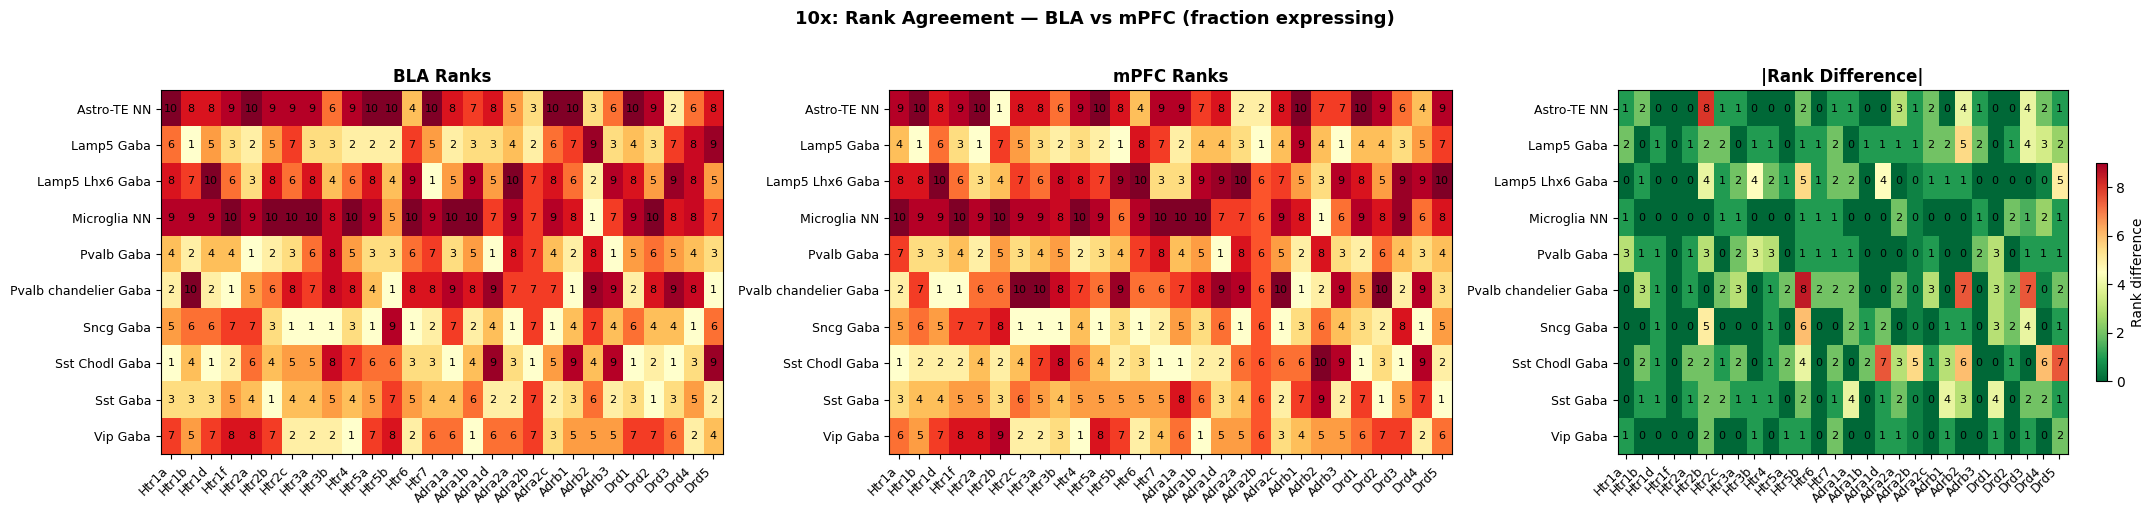

Saved: cross_region_ranks_10x.png


In [10]:
bla_10x_ranks = compute_ranks(bla_10x_frac.loc[tenx_shared_final])
mpfc_10x_ranks = compute_ranks(mpfc_10x_frac.loc[tenx_shared_final])

tenx_rank_diff = plot_rank_agreement(
    bla_10x_ranks, mpfc_10x_ranks, tenx_genes, tenx_shared_final,
    'BLA', 'mPFC',
    '10x: Rank Agreement — BLA vs mPFC (fraction expressing)',
    'cross_region_ranks_10x.png')

## 10. Region-Specific Enrichment

For each gene × cell type, compute the log2 fold-change between BLA and mPFC
mean expression. Positive = higher in BLA, negative = higher in mPFC.

Also show the absolute difference in fraction expressing.

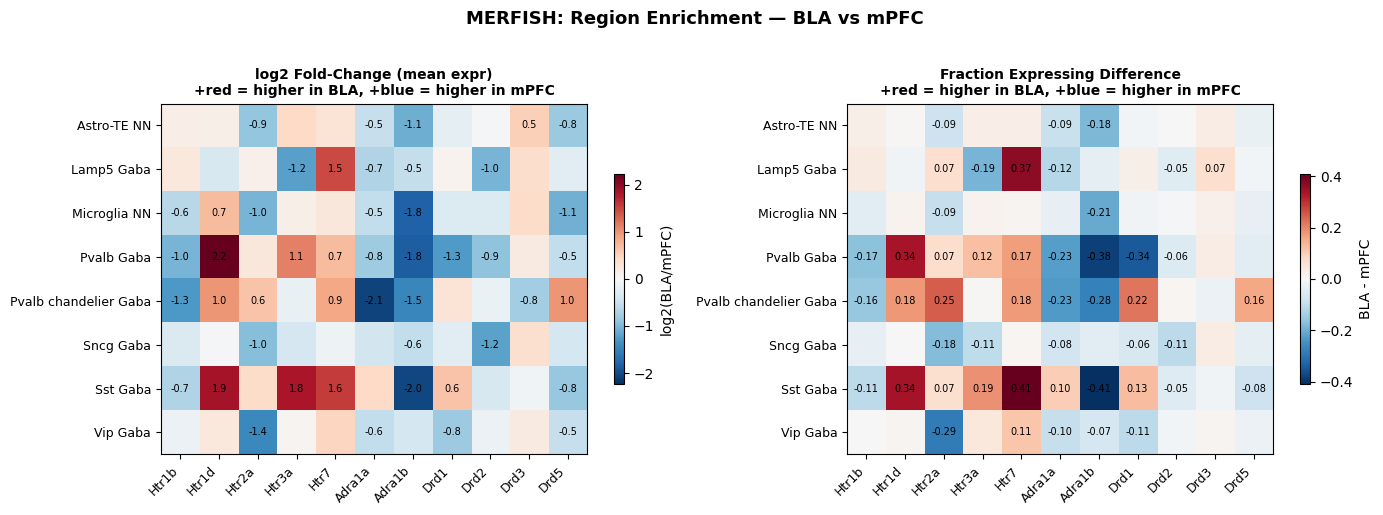

Saved: cross_region_enrichment_merfish.png


In [11]:
def plot_enrichment(mean_a, mean_b, frac_a, frac_b, genes, cell_types,
                    label_a, label_b, modality, filename):
    """Heatmap of region enrichment (fold-change and fraction difference)."""
    # Log2 fold-change of mean expression (add pseudocount for zeros)
    pseudo = 0.01
    log2fc = np.log2((mean_a[genes] + pseudo) / (mean_b[genes] + pseudo))
    
    # Difference in fraction expressing
    frac_diff = frac_a[genes] - frac_b[genes]
    
    n_ct = len(cell_types)
    n_genes = len(genes)
    
    fig, axes = plt.subplots(1, 2, figsize=(max(14, n_genes * 0.8), max(5, n_ct * 0.5)))
    
    # Log2FC heatmap
    vmax_fc = max(abs(log2fc.values.min()), abs(log2fc.values.max()), 2)
    im1 = axes[0].imshow(log2fc.values, cmap='RdBu_r', aspect='auto',
                          vmin=-vmax_fc, vmax=vmax_fc)
    axes[0].set_title(f'log2 Fold-Change (mean expr)\n'
                      f'+red = higher in {label_a}, +blue = higher in {label_b}',
                      fontweight='bold', fontsize=10)
    axes[0].set_yticks(range(n_ct))
    axes[0].set_yticklabels(cell_types, fontsize=9)
    axes[0].set_xticks(range(n_genes))
    axes[0].set_xticklabels(genes, rotation=45, ha='right', fontsize=9)
    plt.colorbar(im1, ax=axes[0], shrink=0.6, label=f'log2({label_a}/{label_b})')
    
    # Annotate with values
    for i in range(n_ct):
        for j in range(n_genes):
            val = log2fc.iloc[i, j]
            if abs(val) > 0.5:
                axes[0].text(j, i, f'{val:.1f}', ha='center', va='center',
                            fontsize=7, color='black')
    
    # Fraction difference heatmap
    vmax_fd = max(abs(frac_diff.values.min()), abs(frac_diff.values.max()), 0.2)
    im2 = axes[1].imshow(frac_diff.values, cmap='RdBu_r', aspect='auto',
                          vmin=-vmax_fd, vmax=vmax_fd)
    axes[1].set_title(f'Fraction Expressing Difference\n'
                      f'+red = higher in {label_a}, +blue = higher in {label_b}',
                      fontweight='bold', fontsize=10)
    axes[1].set_yticks(range(n_ct))
    axes[1].set_yticklabels(cell_types, fontsize=9)
    axes[1].set_xticks(range(n_genes))
    axes[1].set_xticklabels(genes, rotation=45, ha='right', fontsize=9)
    plt.colorbar(im2, ax=axes[1], shrink=0.6, label=f'{label_a} - {label_b}')
    
    for i in range(n_ct):
        for j in range(n_genes):
            val = frac_diff.iloc[i, j]
            if abs(val) > 0.05:
                axes[1].text(j, i, f'{val:.2f}', ha='center', va='center',
                            fontsize=7, color='black')
    
    plt.suptitle(f'{modality}: Region Enrichment — {label_a} vs {label_b}',
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')
    
    return log2fc, frac_diff

mer_log2fc, mer_frac_diff = plot_enrichment(
    bla_mer_mean, mpfc_mer_mean, bla_mer_frac, mpfc_mer_frac,
    merfish_genes, mer_shared_final, 'BLA', 'mPFC', 'MERFISH',
    'cross_region_enrichment_merfish.png')

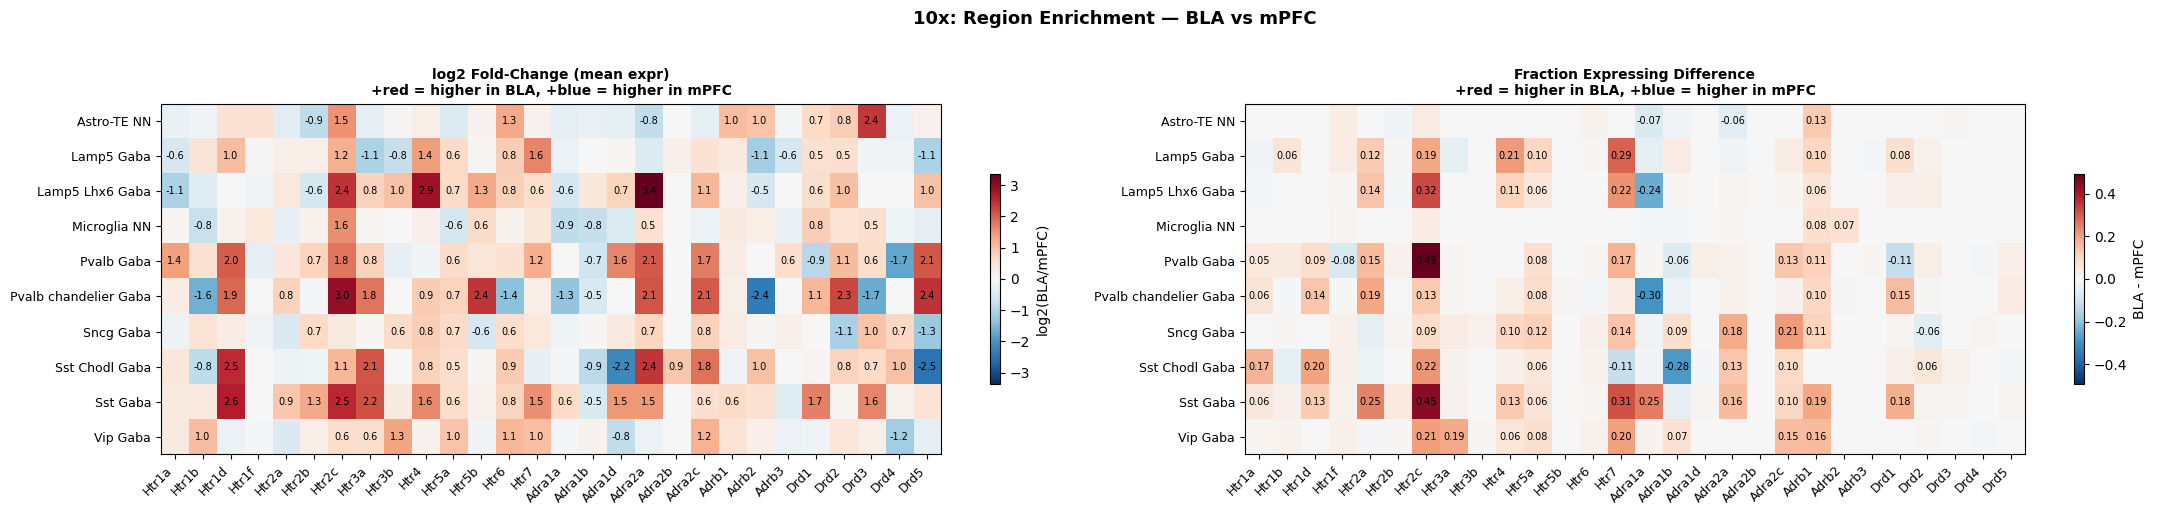

Saved: cross_region_enrichment_10x.png


In [12]:
tenx_log2fc, tenx_frac_diff = plot_enrichment(
    bla_10x_mean, mpfc_10x_mean, bla_10x_frac, mpfc_10x_frac,
    tenx_genes, tenx_shared_final, 'BLA', 'mPFC', '10x',
    'cross_region_enrichment_10x.png')

## 11. Summary: Most Region-Dependent Receptors

Identify which receptors show the largest and most consistent differences
between BLA and mPFC across cell types.

In [13]:
def summarize_enrichment(log2fc, frac_diff, genes, modality):
    """Summarize region enrichment per gene."""
    rows = []
    for g in genes:
        if g not in log2fc.columns:
            continue
        fc_vals = log2fc[g]
        fd_vals = frac_diff[g]
        rows.append({
            'gene': g,
            'mean_log2fc': fc_vals.mean(),
            'abs_mean_log2fc': abs(fc_vals.mean()),
            'max_abs_log2fc': fc_vals.abs().max(),
            'mean_frac_diff': fd_vals.mean(),
            'abs_mean_frac_diff': abs(fd_vals.mean()),
            'n_ct_bla_higher': (fc_vals > 0.5).sum(),
            'n_ct_mpfc_higher': (fc_vals < -0.5).sum(),
            'direction': 'BLA > mPFC' if fc_vals.mean() > 0 else 'mPFC > BLA',
        })
    df = pd.DataFrame(rows).set_index('gene')
    return df.sort_values('abs_mean_log2fc', ascending=False)

print('MERFISH: Region enrichment summary (sorted by |mean log2FC|)')
print('Positive = higher in BLA, negative = higher in mPFC')
print('=' * 80)
mer_summary = summarize_enrichment(mer_log2fc, mer_frac_diff, merfish_genes, 'MERFISH')
display(mer_summary.round(3))

print(f'\n10x: Region enrichment summary (sorted by |mean log2FC|)')
print('Positive = higher in BLA, negative = higher in mPFC')
print('=' * 80)
tenx_summary = summarize_enrichment(tenx_log2fc, tenx_frac_diff, tenx_genes, '10x')
display(tenx_summary.round(3))

MERFISH: Region enrichment summary (sorted by |mean log2FC|)
Positive = higher in BLA, negative = higher in mPFC


,mean_log2fc,abs_mean_log2fc,max_abs_log2fc,mean_frac_diff,abs_mean_frac_diff,n_ct_bla_higher,n_ct_mpfc_higher,direction
gene,,,,,,,,
Adra1b,-1.215,1.215,2.029,-0.201,0.201,0,7,mPFC > BLA
Htr1d,0.722,0.722,2.237,0.110,0.110,4,0,BLA > mPFC
Htr7,0.693,0.693,1.571,0.160,0.160,4,0,BLA > mPFC
Adra1a,-0.642,0.642,2.076,-0.097,0.097,0,6,mPFC > BLA
Drd2,-0.509,0.509,1.198,-0.035,0.035,0,3,mPFC > BLA
Htr1b,-0.463,0.463,1.283,-0.056,0.056,0,4,mPFC > BLA
Drd5,-0.435,0.435,1.080,-0.014,0.014,1,5,mPFC > BLA
Htr2a,-0.363,0.363,1.445,-0.024,0.024,1,4,mPFC > BLA
Drd1,-0.231,0.231,1.272,-0.022,0.022,1,2,mPFC > BLA



10x: Region enrichment summary (sorted by |mean log2FC|)
Positive = higher in BLA, negative = higher in mPFC


,mean_log2fc,abs_mean_log2fc,max_abs_log2fc,mean_frac_diff,abs_mean_frac_diff,n_ct_bla_higher,n_ct_mpfc_higher,direction
gene,,,,,,,,
Htr2c,1.604,1.604,2.971,0.218,0.218,9,0,BLA > mPFC
Adra2a,1.118,1.118,3.367,0.046,0.046,7,1,BLA > mPFC
Htr1d,1.086,1.086,2.649,0.056,0.056,5,0,BLA > mPFC
Adra2c,0.925,0.925,2.058,0.076,0.076,7,0,BLA > mPFC
Htr4,0.874,0.874,2.855,0.067,0.067,6,0,BLA > mPFC
Htr3a,0.690,0.690,2.155,0.023,0.023,6,1,BLA > mPFC
Htr7,0.681,0.681,1.647,0.127,0.127,5,0,BLA > mPFC
Drd2,0.630,0.630,2.256,0.011,0.011,6,1,BLA > mPFC
Htr6,0.547,0.547,1.370,0.010,0.010,7,1,BLA > mPFC


In [14]:
# Save all enrichment data
mer_enrichment_full = pd.DataFrame()
for g in merfish_genes:
    for sc in mer_shared_final:
        mer_enrichment_full = pd.concat([mer_enrichment_full, pd.DataFrame([{
            'modality': 'MERFISH', 'gene': g, 'cell_type': sc,
            'bla_mean': bla_mer_mean.loc[sc, g],
            'mpfc_mean': mpfc_mer_mean.loc[sc, g],
            'bla_frac': bla_mer_frac.loc[sc, g],
            'mpfc_frac': mpfc_mer_frac.loc[sc, g],
            'log2fc': mer_log2fc.loc[sc, g],
            'frac_diff': mer_frac_diff.loc[sc, g],
            'bla_rank': int(bla_mer_ranks.loc[sc, g]),
            'mpfc_rank': int(mpfc_mer_ranks.loc[sc, g]),
        }])])

tenx_enrichment_full = pd.DataFrame()
for g in tenx_genes:
    for sc in tenx_shared_final:
        tenx_enrichment_full = pd.concat([tenx_enrichment_full, pd.DataFrame([{
            'modality': '10x', 'gene': g, 'cell_type': sc,
            'bla_mean': bla_10x_mean.loc[sc, g],
            'mpfc_mean': mpfc_10x_mean.loc[sc, g],
            'bla_frac': bla_10x_frac.loc[sc, g],
            'mpfc_frac': mpfc_10x_frac.loc[sc, g],
            'log2fc': tenx_log2fc.loc[sc, g],
            'frac_diff': tenx_frac_diff.loc[sc, g],
            'bla_rank': int(bla_10x_ranks.loc[sc, g]),
            'mpfc_rank': int(mpfc_10x_ranks.loc[sc, g]),
        }])])

all_enrichment = pd.concat([mer_enrichment_full, tenx_enrichment_full])
all_enrichment.to_csv('cross_region_enrichment.csv', index=False)
print(f'Saved cross_region_enrichment.csv: {len(all_enrichment)} rows')
print(f'  MERFISH: {len(mer_enrichment_full)} entries')
print(f'  10x: {len(tenx_enrichment_full)} entries')

Saved cross_region_enrichment.csv: 368 rows
  MERFISH: 88 entries
  10x: 280 entries
